# This notebook performs the Python-side validation for the SentinelScore rule engine.
All risk logic is deterministic and rule-based, no machine learning is used.

Python was used for:
- Correctness checks
- Explainability
- AUC/precision/recall/F1 validation
- Rule activation inspection
- Feature drift analysis

SQL performs the core operational validation; Python supplements it with analytic metrics.

In [140]:
# Data Load & Set Up #
import pandas as pd
import matplotlib.pyplot as plt
from feature_extractor import extract_features, FeatureInputs
from rule_evaluator import evaluate_rules

tx = pd.read_csv("data_output/layer2/transactions_after_layer2.csv", parse_dates=["created_at"])
sessions = pd.read_csv("data_output/layer2/auth_sessions_after_layer2.csv", parse_dates=["login_at","logout_at"])
merchants = pd.read_csv("data_output/layer1_tx/merchants.csv")
p2p = pd.read_csv("data_output/layer2/p2p_recipients_after_layer2.csv")

inputs = FeatureInputs(
    transactions=tx,
    sessions=sessions,
    merchants=merchants,
    p2p_recipients=p2p
)

features = extract_features(inputs)

decisions_df = pd.read_csv("fraud_decisions.csv")
hits = pd.read_csv("fraud_rule_hits.csv")



In [139]:
# Null / Data Integrity Checks #

print("Null summary:")
df.isna().sum()
print("Rule hit null summary:")
hits.isna().sum()
df.dtypes


Null summary:
Rule hit null summary:


decision_id                       object
txn_id                            object
user_id                           object
decision                          object
risk_score                         int64
reason_codes                      object
created_at_x                      object
label_is_fraud                      bool
created_at_y                      object
velocity_1h                        int64
amount_vs_user_avg_multiplier    float64
predicted_fraud                     bool
dtype: object

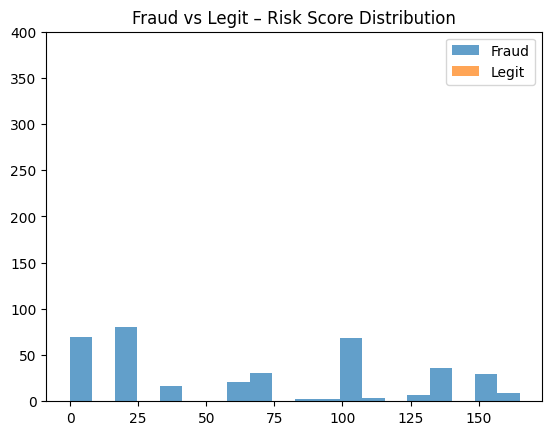

,count,mean,std,min,25%,50%,75%,max
label_is_fraud,,,,,,,,
False,7373.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
True,377.0,67.440318,54.677607,0.0,20.0,70.0,100.0,165.0


In [143]:
# Fraud Vs Legit Score Distribution #
plt.hist(df[df.label_is_fraud == 1].risk_score, bins=20, alpha=0.7, label='Fraud')
plt.hist(df[df.label_is_fraud == 0].risk_score, bins=20, alpha=0.7, label='Legit')
plt.legend()
plt.title("Fraud vs Legit – Risk Score Distribution")
plt.ylim(0, 400)
plt.show()

df.groupby("label_is_fraud")["risk_score"].describe()


In [144]:
# Model Performance Metrics # 

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

df["predicted_fraud"] = df["decision"].isin(["review", "decline"])

auc = roc_auc_score(df.label_is_fraud, df.risk_score)
precision = precision_score(df.label_is_fraud, df.predicted_fraud)
recall = recall_score(df.label_is_fraud, df.predicted_fraud)
f1 = f1_score(df.label_is_fraud, df.predicted_fraud)

auc, precision, recall, f1


(np.float64(0.9071618037135278), 1.0, 0.6021220159151194, 0.7516556291390728)

Rule Activation Frequency:
rule_name
RULE_P2P_HIGH_VELOCITY            270
RULE_HYBRID_ATO_APP_SCAM          190
RULE_AMOUNT_LARGE_DEVIATION       161
RULE_ATO_NEW_DEVICE_FAST_SPEND     86
RULE_DEVICE_MISMATCH               54
RULE_MERCHANT_SPIKE                37
RULE_SESSION_SHORT_LIVED           15
Name: count, dtype: int64


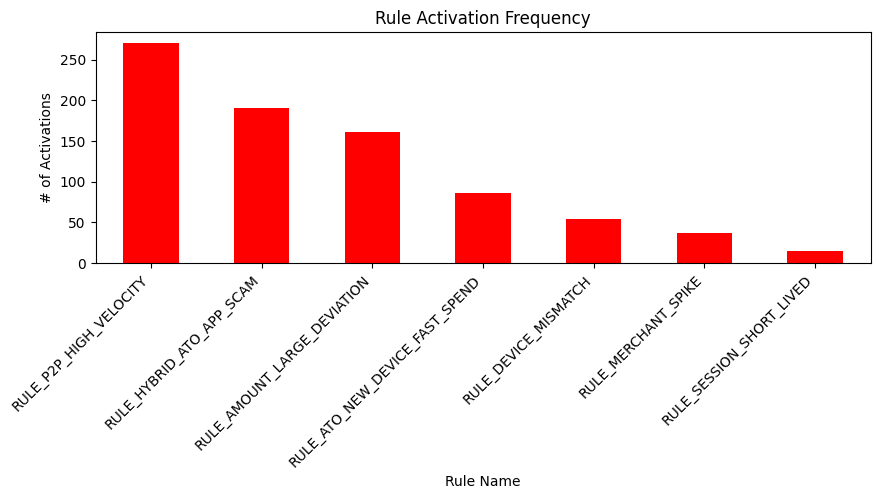

In [145]:
# Rule Activation Frequency #

print("Rule Activation Frequency:")
rule_freq = hits["rule_name"].value_counts()
print(rule_freq)

plt.figure(figsize=(10,3))
rule_freq.plot(
    kind="bar",
    color="red",
    title="Rule Activation Frequency",
)
plt.ylabel("# of Activations")
plt.xlabel("Rule Name")
plt.xticks(rotation=45, ha="right")
plt.show()

Multi-rule stacking distribution:
rule_name
1    96
2    52
3    74
4    43
5    33
6     9
Name: count, dtype: int64


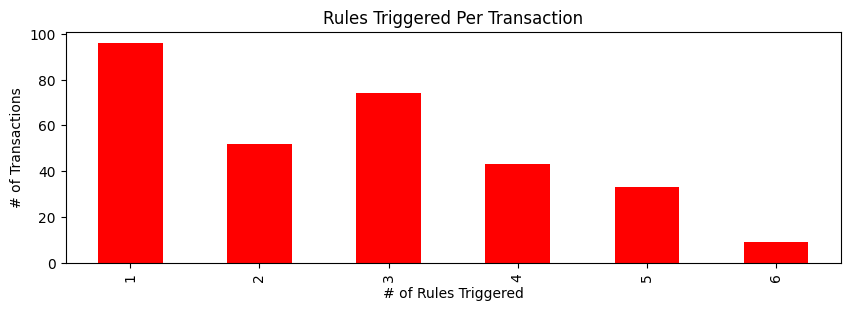

In [146]:
# Multi-Rule Stacking #
stack_counts = (
    hits.groupby("txn_id")["rule_name"]
        .nunique()
        .value_counts()
        .sort_index()
)

print("Multi-rule stacking distribution:")
print(stack_counts)
plt.figure(figsize=(10,3))
stack_counts.plot(
    kind="bar",
    color="red",
    title="Rules Triggered Per Transaction",
)
plt.ylabel("# of Transactions")
plt.xlabel("# of Rules Triggered")
plt.show()


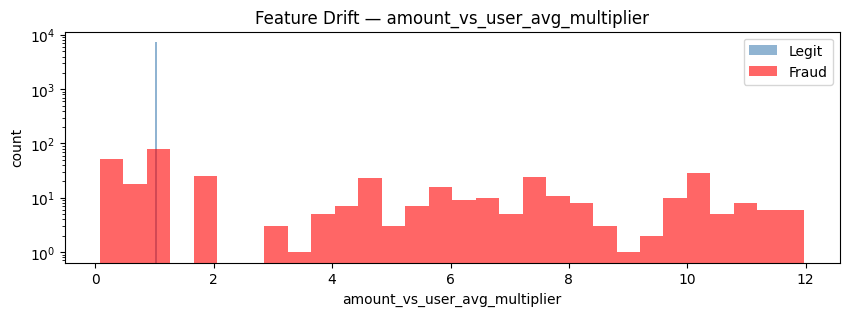

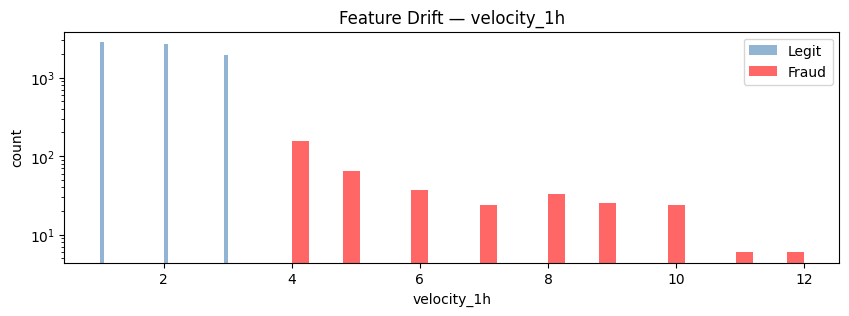

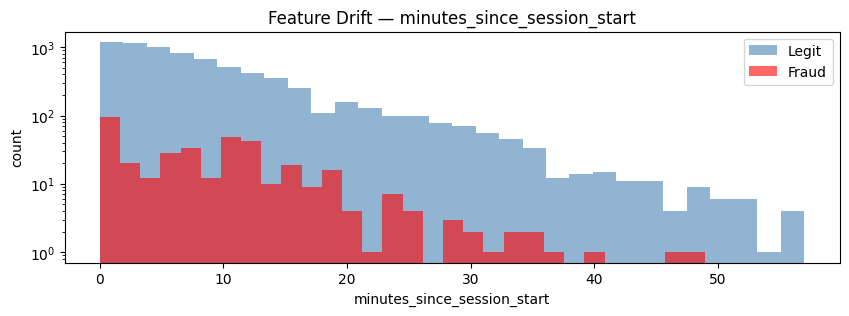

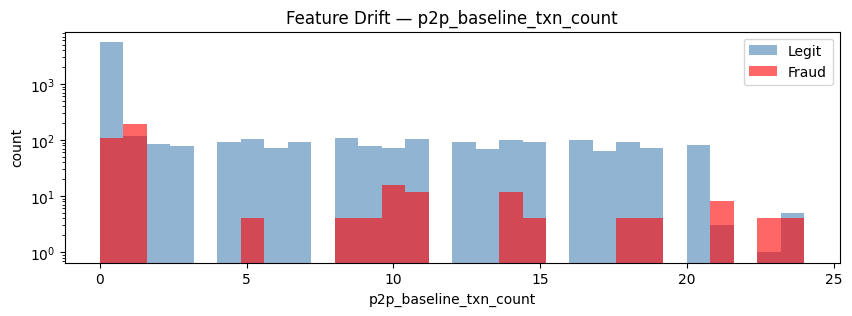

In [148]:
# Feature Drift #
# Purpose: Validates that injected fraud scenarios meaningfully push features away from normal user behavior.
fraud = features[features["label_is_fraud"] == True]
legit = features[features["label_is_fraud"] == False]

drift_features = [
    "amount_vs_user_avg_multiplier",
    "velocity_1h",
    "minutes_since_session_start",
    "p2p_baseline_txn_count",
]

for feat in drift_features:
    plt.figure(figsize=(10,3))
    plt.hist(legit[feat], bins=30, alpha=0.6, label="Legit", color="steelblue")
    plt.hist(fraud[feat], bins=30, alpha=0.6, label="Fraud", color="red")
    plt.title(f"Feature Drift — {feat}")
    plt.legend()
    plt.xlabel(feat)
    plt.ylabel("count")
    plt.yscale("log")
    plt.show()


Top Reason Codes:
signal_values
{"reason": "P2P burst velocity: 4 transfers in <1 hour."}     102
{"reason": "P2P burst velocity: 8 transfers in <1 hour."}      33
{"reason": "Spend multiplier 10.0\u00d7 exceeds 5\u00d7."}     25
{"reason": "P2P burst velocity: 5 transfers in <1 hour."}      25
{"reason": "P2P burst velocity: 6 transfers in <1 hour."}      25
{"reason": "P2P burst velocity: 9 transfers in <1 hour."}      25
{"reason": "P2P burst velocity: 7 transfers in <1 hour."}      24
{"reason": "P2P burst velocity: 10 transfers in <1 hour."}     24
{"reason": "Spend multiplier 7.33\u00d7 exceeds 5\u00d7."}     13
{"reason": "Spend multiplier 6.0\u00d7 exceeds 5\u00d7."}      12
Name: count, dtype: int64


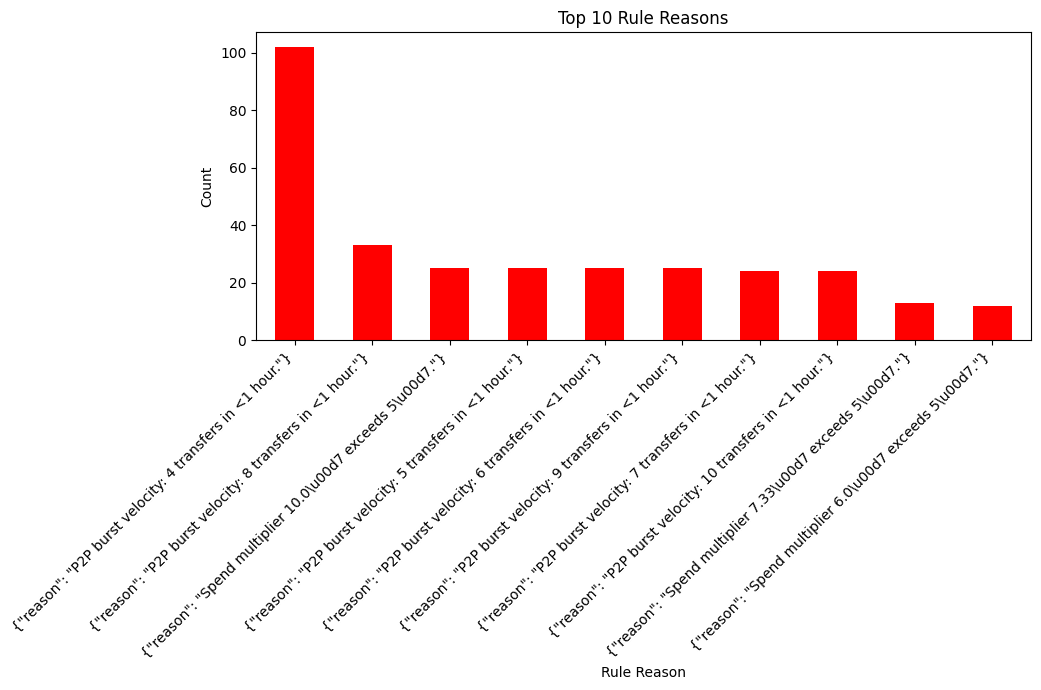

In [149]:
# Top Reason Codes
# Purpose: Verifys that reason codes are understandable, consistent, and align with the rule triggers.
top_reasons = (
    hits['signal_values']
        .value_counts()
        .head(10)
)

print("Top Reason Codes:")
print(top_reasons)

plt.figure(figsize=(10,4))
top_reasons.plot(
    kind="bar", 
    color="red", 
    title="Top 10 Rule Reasons",
)
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Rule Reason")
plt.show()

In [150]:
# Case Track - Caught Fraud #
# Purpose: Walk through a correctly identified fraud case end 2 end showing decisioning, 
#          feature values that drove decisioning and rules/reasons codes triggered.
caught = df[(df["label_is_fraud"] == True) & (df["risk_score"] > 0)].sample(1).iloc[0]
txn_id = caught["txn_id"]

print("=== Fraud Case Trace (Caught Fraud) ===")
print("Transaction ID:", txn_id)

print("\n----- Decision -----")
print(caught[["decision", "risk_score", "reason_codes", "label_is_fraud"]])

feature_row = features[features["txn_id"] == txn_id].iloc[0]

print("\n----- Feature Snapshot -----")
print(feature_row[[
    "amount",
    "txn_type",
    "velocity_1h",
    "amount_vs_user_avg_multiplier",
    "minutes_since_session_start",
    "is_new_device_for_user",
    "is_first_time_recipient"
]])

print("\n----- Rule Hits -----")
case_hits = hits[hits["txn_id"] == txn_id][["rule_name", "severity", "signal_values"]]
print(case_hits)



=== Fraud Case Trace (Caught Fraud) ===
Transaction ID: abcff4a5-4fbb-46ba-8469-1900cd3d9d93

----- Decision -----
decision                                                    decline
risk_score                                                       70
reason_codes      ["RULE_HYBRID_ATO_APP_SCAM", "RULE_P2P_HIGH_VE...
label_is_fraud                                                 True
Name: 1406, dtype: object

----- Feature Snapshot -----
amount                           134.42
txn_type                            p2p
velocity_1h                           8
amount_vs_user_avg_multiplier       2.0
minutes_since_session_start          10
is_new_device_for_user             True
is_first_time_recipient            True
Name: 4507, dtype: object

----- Rule Hits -----
                    rule_name  severity  \
432  RULE_HYBRID_ATO_APP_SCAM  critical   
433    RULE_P2P_HIGH_VELOCITY    medium   

                                         signal_values  
432  {"reason": "High-velocity first-time

In [152]:
# Case Track - (False Negative Detection Test)
# Purpose: To evaluate recall and understand which injected fraud patterns slip through the rule engine.
# The following transaction was labeled fraud but received a risk_score of 0 and was approved.
# This is an expected limitation of strict rule based systems when fraud mimics normal behavior.

missed = df[(df["label_is_fraud"] == True) & (df["risk_score"] == 0)]

missed_case = missed.head(1)
missed_case

txn_id = missed_case["txn_id"].iloc[0]

print("=== Missed Fraud Case (False Negative) ===")
print("Transaction ID:", txn_id)
print("Decision:")
display(decisions_df[decisions_df["txn_id"] == txn_id])

print("Feature Snapshot:")
cols = [
    "amount",
    "txn_type",
    "velocity_1h",
    "amount_vs_user_avg_multiplier",
    "minutes_since_session_start",
    "is_new_device_for_user",
    "is_first_time_recipient"
]
display(features[features["txn_id"] == txn_id][cols])

print("Rule Hits:")
display(hits[hits["txn_id"] == txn_id][["rule_name", "severity", "signal_values"]])

# Why This Fraud Was Missed:
#-No first-time recipient
#-No new device
#-No early-session automation behavior
#-No high-velocity spike for this merchant category
#-Multiplier within normal bounds

# This pattern did not satisfy any rule conditions; therefore rule_hits was empty.
# false negatives are expected in deterministic heuristics.


=== Missed Fraud Case (False Negative) ===
Transaction ID: cf6459d6-ce84-444b-b5f3-9b56eaacd8c4
Decision:


,decision_id,txn_id,user_id,decision,risk_score,reason_codes,created_at
7643,aef3c696-33bd-44e6-aa1a-66c3f1df2da1,cf6459d6-ce84-444b-b5f3-9b56eaacd8c4,cd6c2140-8f9a-4dc9-9afa-fc5f8ec73698,approve,0,[],2025-12-02T01:49:07.518888+00:00


Feature Snapshot:


,amount,txn_type,velocity_1h,amount_vs_user_avg_multiplier,minutes_since_session_start,is_new_device_for_user,is_first_time_recipient
1897,17.55,merchant,5,0.659,15,False,False


Rule Hits:


,rule_name,severity,signal_values
